# Prepare CIFAR10 dataset on harddisk

In [1]:
# 1. Load the CIFAR 10 dataset to the RAM
import torchvision
download_folder = "data"
trainset = torchvision.datasets.CIFAR10(root=download_folder, train=True, download=True)
testset  = torchvision.datasets.CIFAR10(root=download_folder, train=False, download=True)

# 2. Save all images in the usual folder structure
import os

def save_images(dataset, rootfolder):

    os.makedirs(rootfolder, exist_ok=True)

    # make subdirs
    for class_name in dataset.classes:
        folder = f"{rootfolder}/{class_name}"
        os.makedirs(folder, exist_ok=True)

    # count nr of images per class
    img_counter = {class_name : 0 for class_name in dataset.classes}

    # save each image in its corresponding folder
    for img, label in dataset:
        class_name = dataset.classes[label]
        img_counter[class_name] += 1
        img_fname = f"{rootfolder}/{class_name}/{img_counter[class_name]:04}.png"
        img.save(img_fname)

    return img_counter

img_counters = save_images(trainset, "cifar10_images/train")
print("Training images:")
print(img_counters)

img_counters = save_images(testset, "cifar10_images/test")
print("Test images:")
print(img_counters)

100%|██████████| 170M/170M [00:05<00:00, 30.0MB/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Training images:
{'airplane': 5000, 'automobile': 5000, 'bird': 5000, 'cat': 5000, 'deer': 5000, 'dog': 5000, 'frog': 5000, 'horse': 5000, 'ship': 5000, 'truck': 5000}
Test images:
{'airplane': 1000, 'automobile': 1000, 'bird': 1000, 'cat': 1000, 'deer': 1000, 'dog': 1000, 'frog': 1000, 'horse': 1000, 'ship': 1000, 'truck': 1000}


# Define a CNN model and train it

In [2]:
!pip install torchinfo

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 32, 32]           896
├─MaxPool2d: 1-2                         [1, 32, 16, 16]           --
├─Conv2d: 1-3                            [1, 64, 16, 16]           18,496
├─MaxPool2d: 1-4                         [1, 64, 8, 8]             --
├─Conv2d: 1-5                            [1, 128, 8, 8]            73,856
├─MaxPool2d: 1-6                         [1, 128, 4, 4]            --
├─Linear: 1-7                            [1, 256]                  524,544
├─Dropout: 1-8                           [1, 256]                  --
├─Linear: 1-9                            [1, 10]                   2,570
Total params: 620,362
Trainable params: 620,362
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 10.91
Input size (MB): 0.01
Forward/backward pass size (MB): 0.46
Params size (MB): 2.48
Estimated To

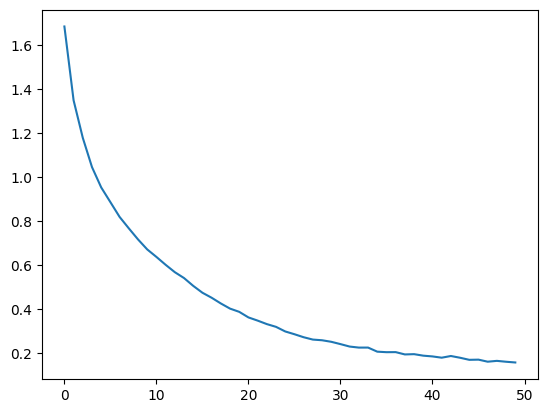

In [4]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import optim


# 1. Prepare access to the train dataset
img_transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.ImageFolder(root="cifar10_images/train",
                                     transform=img_transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)


# 2. Define CNN model
class SimpleCNN(nn.Module):
    def __init__(self, input_shape=(3, 32, 32)):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # How many neurons for the 1st layer of the MLP?
        self.flattened_size = self._get_flattened_size(input_shape)

        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, 10)

        self.dropout = nn.Dropout(p=0.5)

    def _get_flattened_size(self, input_shape):
        with torch.no_grad():
            x = torch.zeros(1, *input_shape)  # Run dummy tensor ...
            x = self._feature_extractor(x)    # ... through the feature extractur ...
            return x.view(1, -1).shape[1]     # ... in order to determine the flattened vector size

    def _feature_extractor(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        return x

    def forward(self, x):
        x = self._feature_extractor(x)
        x = x.view(x.shape[0], -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

from torchinfo import summary
print(summary(model, input_size=(1, 3, 32, 32)))


# 3. Training

# Define loss and otimizer to be used
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
nr_epochs = 50
losses = []
for epoch in range(nr_epochs):
    running_loss = 0.0
    batch_nr = 0
    for images, labels in train_loader:
        batch_nr += 1
        if batch_nr % 100 == 0:
            print(f"{batch_nr}", end=" ")
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss_per_batch = running_loss/len(train_loader)
    print(f"\nEpoch {epoch+1}, Loss: {avg_loss_per_batch:.4f}")
    losses.append(avg_loss_per_batch)

print("Training finished!")

import matplotlib.pyplot as plt
plt.plot( losses )
plt.show()

# Test the CNN

In [5]:
model.eval()

# 1. Testdatensatz vorbereiten
img_transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.ImageFolder(root="cifar10_images/test",
                                     transform=img_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    # Keine Gradientenberechnung während der Vorhersage
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    print(predicted)
    print(labels)
    break

tensor([8, 0, 2, 0, 0, 2, 9, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0,
        0, 0, 0, 8, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 8, 0, 9, 8, 0, 0, 0, 6, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 9, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


tensor([8, 0, 2, 0, 0, 2, 9, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0,
        0, 0, 0, 8, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 8, 0, 9, 8, 0, 0, 0, 6, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 9, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


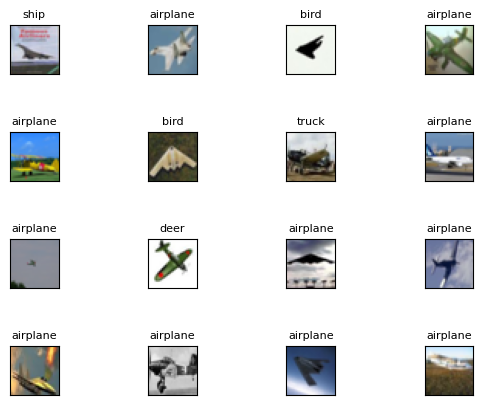

In [6]:
model.eval()

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    # no gradient calculation during prediction
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    # assuming that the batch_size is at least 16
    for idx in range(4*4):
        plt.subplot(4,4,idx+1)
        plt.subplot(4,4, idx+1)
        plt.imshow( images[idx].cpu().permute(1,2,0) )
        plt.xticks([])
        plt.yticks([])

        predicted_id = predicted[idx]
        plt.title( f"{train_dataset.classes[predicted_id]}", fontsize=8 )

    # units here are relative to height and width of a subplot
    plt.subplots_adjust(hspace=1.2, wspace=0.7)

    print(predicted)
    print(labels)
    break

In [7]:
model.eval()

correct = 0
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    # no gradient calculation during prediction
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    correct += sum(predicted == labels).item()

print(f"Accuracy: {(correct/len(test_dataset))*100.0}")

Accuracy: 75.33999999999999
